# Tuning Confidence Score of Flight Call Detections
_Ashley Huang, Carlene English_, _Benjamin Van Doren_, _Kate Stone_

In [11]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score, precision_recall_curve
from scipy.stats import gaussian_kde
from scipy.special import logit
from scipy.interpolate import interp1d
from matplotlib import pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import suncalc
import os
for path in ['exports', 'exports/csv', 'exports/figures']:
    if not os.path.exists(path):
        os.makedirs(path)

In [12]:
taxon = 'uplsan'

common_names = {
    'greyel': 'Greater Yellowlegs', 
    'semplo': 'Semipalmated Plover', 
    'lobcur': 'Long-billed Curlew', 
    'uplsan': 'Upland Sandpiper', 
    'baisan': 'Baird\'s Sandpiper', 
    'wilsni': 'Wilson\'s Snipe', 
    'leasan': 'Least Sandpiper'
}

## 1. Plot the distribution of confidence scores
To avoid confusion for the term ***reviewed***, we will be using ***Present*** and ***Absent*** when refering to review status.

`reviewStatus: Reviewed` -> ***Present***

`reviewStatus: Problem` -> ***Absent***

***Present*** or ***Absent*** -> ***Reviewed***

`reviewStatus: Unreviewed` -> ***Unreviewed***

reviewStatus
Unreviewed    2772
Absent         413
Present        155
Name: count, dtype: int64

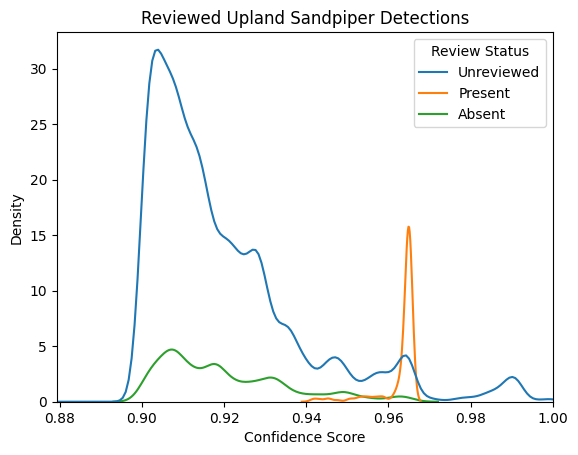

In [13]:
if taxon == 'uplsan':
    df_flood = pd.read_csv(f'detections/uplsan_flood.csv')
    df_present = pd.read_csv(f'detections/uplsan_correct.csv')
    df_absent = pd.read_csv(f'detections/uplsan_incorrect.csv')
    df = pd.concat([df_flood, df_present, df_absent])
else:
    df = pd.read_csv(f'detections/{taxon}.csv')

df = df[df['detectionModel'] == 'nfc_taxo141']
df['reviewStatus'] = df['reviewStatus'].map({'Reviewed': 'Present', 
                                             'Problem': 'Absent', 
                                             'Unreviewed': 'Unreviewed'})
df['reviewStatusBinary'] = df['reviewStatus'].map({'Present': 1, 
                                                   'Absent': 0, 
                                                   'Unreviewed': -1})

ax = sns.kdeplot(df, x='confidenceScore', hue='reviewStatus', bw_adjust=0.5)
ax.get_legend().set_title('Review Status')
plt.title(f'Reviewed {common_names[taxon]} Detections')
plt.xlabel('Confidence Score')
plt.xlim(df['confidenceScore'].quantile(1e-4), 1)
plt.savefig(f'exports/figures/before_{taxon}.png')

df['reviewStatus'].value_counts()

## 2. Filter Out Daytime Detections
First, we filter out unreviewed detections and assign 0/1 to absent/present detections. Then, we filter out daytime flight calls. Timestamps are compared to the sunset/sunrise time of MPG ranch. Once we obtained coordinated of each site, timestamp should be compared to the sunset/sunrise time of the corresponding site.

In [14]:
# Filter by sunset and sunrise time
def get_sameday_dawn_dusk(utc_time, lon, lat):
    # Turns out Suncalc doesn't return the times of the same day. 
    # Instead, if the time has passed sunset, Suncalc returns the times of the next day.
    next_sunset = suncalc.get_times(utc_time, lon, lat)
    prev_sunset = suncalc.get_times(utc_time - timedelta(days=1), lon, lat)
    if (next_sunset['nautical_dawn'] - timedelta(hours=6)).date() == (utc_time - timedelta(hours=6)).date():
        utc_dawn, utc_dusk = next_sunset['nautical_dawn'], next_sunset['nautical_dusk']
    else:
        utc_dawn, utc_dusk = prev_sunset['nautical_dawn'], prev_sunset['nautical_dusk']
    assert((utc_dawn - timedelta(hours=6)).date() == (utc_time - timedelta(hours=6)).date())
    assert((utc_dusk - timedelta(hours=6)).date() == (utc_time - timedelta(hours=6)).date())
    return utc_dawn, utc_dusk

def is_nocturnal(time_str, dawn_offset=timedelta(minutes=0), dusk_offset=timedelta(minutes=0)):
    utc_time = datetime.strptime(time_str, '%Y-%m-%dT%H:%M:%S.%fZ')
    utc_dawn, utc_dusk = get_sameday_dawn_dusk(utc_time, -116.3273099, 47.0559593)
    if utc_dawn + dawn_offset < utc_time < utc_dusk + dusk_offset:
        return False
    else:
        return True

total_detections = len(df.index) * 1
df = df[df['timestamp'].apply(is_nocturnal)]
print('nocturnal detections:', len(df.index))
print('durinal detections:', total_detections - len(df.index))

nocturnal detections: 693
durinal detections: 2647


## 3. Resample Reviewed Detections to Match the Distribution of All Detections

In [15]:
scores_target = df['confidenceScore']
scores_reviewed = df[df['reviewStatus'] != 'Unreviewed']['confidenceScore']
kde_target = gaussian_kde(scores_target, bw_method=1)
kde_reviewed = gaussian_kde(scores_reviewed, bw_method=1)
weights = kde_target.evaluate(scores_reviewed) / kde_reviewed.evaluate(scores_reviewed)
weights /= weights.sum()

sample_size = len(df[df['reviewStatus'] != 'Unreviewed'])
indicies = np.random.choice(df[df['reviewStatus'] != 'Unreviewed'].index, size=sample_size, p=weights, replace=True)
sample = df[df['reviewStatus'] != 'Unreviewed'].loc[indicies]

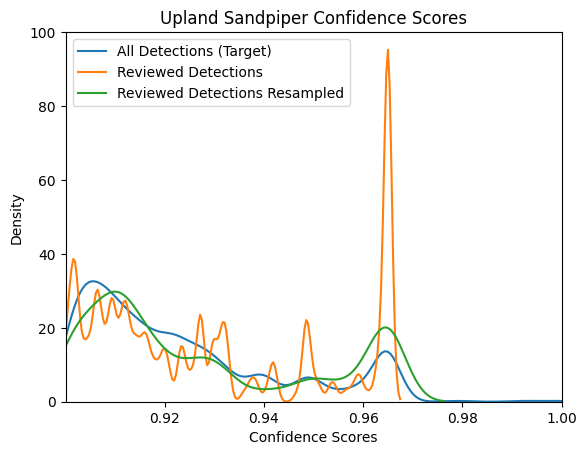

In [16]:
# Plot the distribution before and after resampling
sns.kdeplot(df['confidenceScore'], bw_adjust=0.5, color='#1f77b4', label='All Detections (Target)')
sns.kdeplot(df[df['reviewStatus'] != 'Unreviewed']['confidenceScore'].values, bw_adjust=1e-1, color='#ff7f0e', label='Reviewed Detections')
sns.kdeplot(sample['confidenceScore'], bw_adjust=0.5, color='#2ca02c', label='Reviewed Detections Resampled')
plt.title(f'{common_names[taxon]} Confidence Scores')
plt.xlabel('Confidence Scores')
plt.xlim(df['confidenceScore'].quantile(1e-4), 1)
plt.legend()

## 5. Fit with Logistic Regression

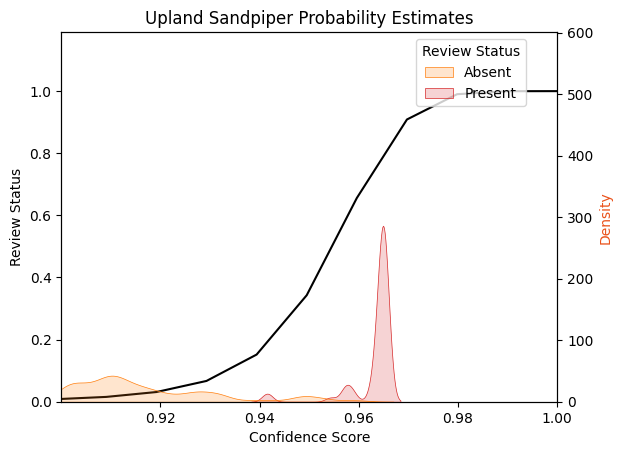

In [17]:
X = sample['confidenceScore'].values.reshape(-1, 1)
y = sample['reviewStatusBinary'].values
X_logit = logit(X.clip(1e-4, 1 - 1e-4)) # apply logit
logr = LogisticRegression()
logr.fit(X_logit, y)

# Predict y of x in [0, 1]
X = np.linspace(0, 1, 100).reshape(-1, 1)
X_logit = logit(X.clip(1e-4, 1 - 1e-4)) # apply logit
y_hat = logr.predict_proba(X_logit)[:, 1]

fig, ax1 = plt.subplots()
ax1.plot(X, y_hat, color='black')
ax1.set_xlim(df['confidenceScore'].quantile(1e-4), 1)
ax1.set_ylim(0, 1.19)
ax1.set_xlabel('Confidence Score')
ax1.set_ylabel('Review Status')
ax1.set_title(f'{common_names[taxon]} Probability Estimates')
plt.savefig(f'exports/figures/prob_{taxon}.png')

ax2 = ax1.twinx()
sns.kdeplot(data=sample, x='confidenceScore', hue='reviewStatus', bw_adjust=0.5, 
            fill=True, alpha=0.2, common_norm=False, palette=['#ff7f0e', '#d62728'], linewidth=0.5, 
            ax=ax2)
ax2.set_ylabel('Density', color='#ea521b')
ax2.set_ylim(0, ax2.get_ylim()[1] * 2) # Scale KDE by 1/2 to not clutter up the figure
ax2.get_legend().set_title('Review Status')
ax2.get_legend().set_bbox_to_anchor((0.95, 1))

plt.savefig(f'exports/figures/prob_w_dist_{taxon}.png')

At probability = 0.9
--- Precision = 1.0
--- Recall = 0.05357


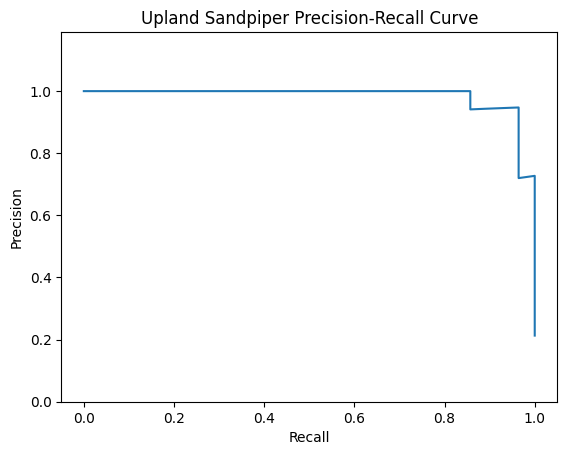

In [18]:
# Train logistic regression model
X = sample['confidenceScore'].values.reshape(-1, 1)
y = sample['reviewStatusBinary'].values
X_logit = logit(X.clip(1e-4, 1 - 1e-4)) # apply logit
y_hat = logr.predict_proba(X_logit)[:, 1]

precision, recall, threshold = precision_recall_curve(y, y_hat)
average_precision = average_precision_score(y, y_hat)
plt.plot(recall, precision)
plt.title(f'{common_names[taxon]} Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim(0, 1.19)

# Find precision and recall at target probability
target_probability = 0.90
target_idx = np.argmin(np.abs(threshold - target_probability))
p_at_target = precision[target_idx]
r_at_target = recall[target_idx]
print(f'At probability = {target_probability}')
print(f'--- Precision = {p_at_target.round(5)}')
print(f'--- Recall = {r_at_target.round(5)}')
# with open('exports/dump.txt', 'a') as dump:
    # dump.write(f'{p_at_target.round(5)}, {r_at_target.round(5)}\n')

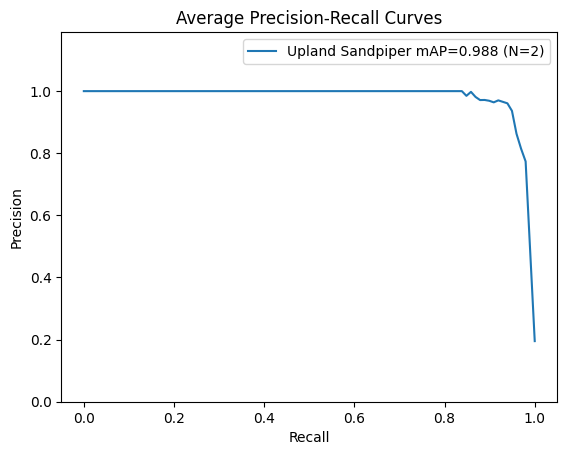

In [19]:
try:
    pr_curves[taxon].append((precision, recall))
    average_precisions[taxon].append(average_precision)
except KeyError:
    pr_curves[taxon] = [(precision, recall)]
    average_precisions[taxon] = [average_precision]
except NameError:
    pr_curves = {taxon: [(precision, recall)]}
    average_precisions = {taxon: [average_precision]}

# Plot average precision-recall curve
for t, pr_curve in pr_curves.items():
    recall_interp = np.linspace(0, 1, 100)
    precision_interp = list()
    for precision, recall in pr_curve:
        f = interp1d(recall, precision, kind='linear', bounds_error=False, fill_value='extrapolate')
        precision_interp.append(f(recall_interp))
        # plt.plot(recall, precision, alpha=0.2)
    mean_precision_interp = np.mean(precision_interp, axis=0)
    mean_average_precision = np.mean(average_precisions[t])
    plt.plot(recall_interp, mean_precision_interp, label=f'{common_names[t]} mAP={mean_average_precision.round(3)} (N={len(pr_curve)})')

plt.title('Average Precision-Recall Curves')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim(0, 1.19)
plt.legend()
plt.savefig(f'exports/figures/average_pr_curves.png')

In [20]:
import zipfile

with zipfile.ZipFile('coords/ARULocations2017.kmz', 'r') as kmz:
    kmz.extractall('coords/ARULocations2017.kml')

with zipfile.ZipFile('coords/ARULocations2018.kmz', 'r') as kmz:
    kmz.extractall('coords/ARULocations2018.kml')